In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from glob import glob

In [3]:
df = pd.DataFrame()
for f in glob("datasets/*.csv"):
    df = pd.concat([df, pd.read_csv(f)], ignore_index=True)
df["pseudchartTime"] = pd.to_datetime(df["pseudchartTime"], format="%d/%m/%Y %H:%M")

In [4]:
columns = [
    "pO2 kPa (ABL)",
    "pCO2 kPA (ABL)",
    "Na+ mmol/L (ABL)",
    "Ca++ mmol/L (ABL)",
    "Cl- mmol/L (ABL)",
    "Lactate mmol/L (ABL)",
    "Albumin",
    "Urea",
    "Phosphate",
    "pH (ABL)",
]
sample = df.query("longLabel in @columns")
sample = sample.pivot_table(
    index=["alias", "pseudchartTime"], columns="longLabel", values="valueNumber"
).reset_index()
sample["alias"] = (
    sample["alias"].str.split("-").str[1].apply(lambda x: f"G-{int(x):02}")
)

In [5]:
data = sample.copy()
data = data.rename(
    {
        "pCO2 kPA (ABL)": "pco2",
        "pO2 kPa (ABL)": "po2",
        "Na+ mmol/L (ABL)": "na",
        "Cl- mmol/L (ABL)": "cl",
        "Ca++ mmol/L (ABL)": "ca",
        "Albumin": "albumin",
        "Lactate mmol/L (ABL)": "lactate",
        "Urea": "urea",
        "Phosphate": "phosphate",
        "pH (ABL)": "ph",
    },
    axis=1,
)

data = data.sort_values(["alias", "pseudchartTime"])
data["sid"] = data["na"] + data["ca"] - data["cl"]
data_gap = data.copy()

# ffill albumin
for col in ["albumin", "phosphate", "urea"]:
    data[col] = data.groupby("alias")[col].ffill()
    data[col] = data.groupby("alias")[col].bfill()

# data = data.dropna()

# Interpolation

In [10]:
from interpolations import *

agg_patient = (
    data_gap.groupby(["alias", pd.Grouper(key="pseudchartTime", freq="1h")])
    .mean(numeric_only=True)
    .reset_index()
    .copy()
)
agg_patient["unix_timestamp"] = agg_patient["pseudchartTime"].astype(int) / 1e9 / 3600


def get_patient(agg_patient, alias, admission=None):
    patient = agg_patient.query("alias == @alias")
    if admission is not None:
        patient = patient.query("admission == @admission")
    patient = (
        patient.set_index("pseudchartTime")
        .resample("1h")
        .mean(numeric_only=True)
        .reset_index()
        .copy()
    )
    patient["unix_timestamp"] = patient["pseudchartTime"].astype(int) / 1e9 / 3600
    return patient

In [11]:
from sklearn.cluster import DBSCAN

mdl = DBSCAN(eps=24 * 7)
agg_patient["admission"] = mdl.fit_predict(agg_patient[["unix_timestamp"]])
agg_patient["window"] = agg_patient.apply(
    lambda x: f"{x.alias} + {x.admission}", axis=1
)

In [12]:
agg_patient.groupby(["alias", "admission"]).size()

alias  admission
G-01    0            55
G-02    1            41
G-03   -1             7
        2            43
G-04    3            17
G-05    3            67
G-06    4            56
G-07    5            54
G-08    6             9
G-09    7            23
G-10    8           124
        9            84
G-11    10           13
G-12   -1             4
        11           49
        12           30
        13           23
G-13    14           74
G-14    15           69
dtype: int64

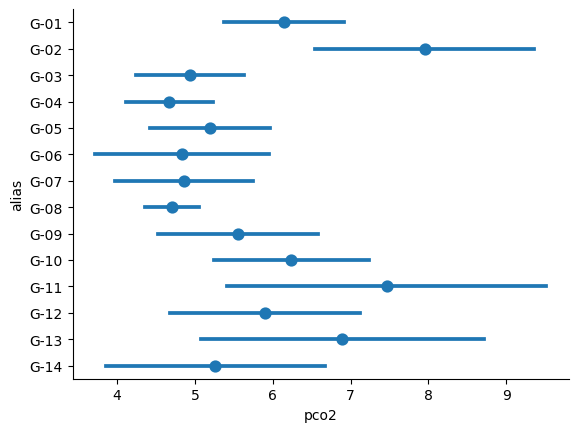

In [13]:
sns.pointplot(
    x="pco2",
    y="alias",
    errorbar="sd",
    linestyle="none",
    data=agg_patient,
)
sns.despine()

In [14]:
from enum import Enum
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

import dgpsi as dgp

# Linked GP

In [15]:
window = "G-07 + 5"
features = [
    "pco2",
    "sid",
    "lactate",
]

alias, admission = window.split(" + ")
admission = int(admission)

patient_per_hour = get_patient(agg_patient, alias, admission)
patient_df = patient_per_hour.dropna(subset="ph").copy()
# patient_df['all_na'] = np.nan

y_scaler = StandardScaler()
Y = y_scaler.fit_transform(patient_df[["ph"]].values)

X = patient_df[["unix_timestamp"]].values
X = (X - X.min()) / (X.max() - X.min())

scaler = StandardScaler()
H = scaler.fit_transform(patient_df[features].values)

In [37]:
import dgpsi as dgp


class LinkedGP:
    def __init__(self, features: list[str]):
        self.is_fitted = False
        self.features = features
        self._input_models = []
        self._output_model = None

    @classmethod
    def train_gp_complete_case(cls, X, H, **kwargs):
        x = np.hstack([X, H])
        mask_not_nan = ~np.isnan(x).reshape(x.shape[0], -1).sum(axis=1).astype(bool)
        model = dgp.gp(
            X[mask_not_nan],
            H[mask_not_nan].reshape(-1, 1),
            dgp.kernel(**kwargs),
        )

        model.train()
        return model

    def link_models(self, input_models, output_model):
        input_models_container = []
        for model in input_models:
            input_models_container.append(
                dgp.container(model.export(), local_input_idx=np.array([0]))
            )

        output_container = [
            dgp.container(output_model.export(), local_input_idx=np.arange(len(self.features)))
        ]

        struc = [input_models_container, output_container]
        lm = dgp.lgp(struc)
        return lm

    def fit(self, X, H, Y):
        kernel_args = dict(
            length=np.array([0.5]),
            name="sexp",
            scale_est=False,
        )

        for i, feature in enumerate(self.features):
            self._input_models.append(
                self.train_gp_complete_case(
                    X=X,
                    H=H[:, i].reshape(-1, 1),
                    nugget_est=False,
                    nugget=1e-6,
                    **kernel_args
                )
            )

        self._output_model = self.train_gp_complete_case(
            X=H, H=Y, nugget_est=True, nugget=1e-3, **kernel_args
        )

        self.lm = self.link_models(
            input_models=self._input_models, output_model=self._output_model
        )
        self.is_fitted = True

    def predict(self, X, full_layer=False):
        """Returns mean and var by default"""
        if self.is_fitted:
            return self.lm.predict(X, full_layer=full_layer)
        else:
            raise Exception("Model is not fitted.")

## Modelling time $\rightarrow$ (pCO2, SID, lactate) $\rightarrow$ pH

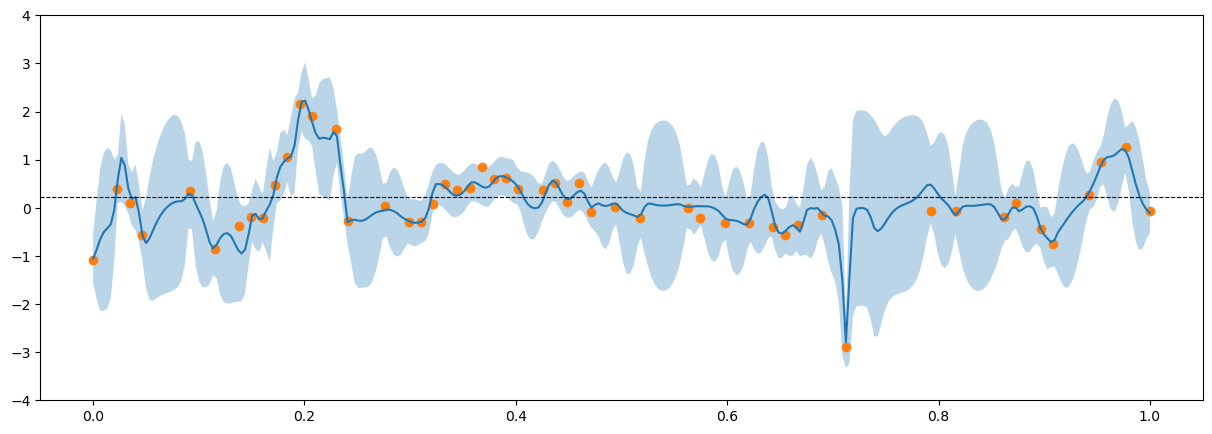

In [32]:
linked_gp = LinkedGP(features=features)
linked_gp.fit(X, H, Y)

z = np.linspace(0, 1, 300)[:, None].reshape(-1, 1)
ml, vl = linked_gp.predict(z)
lbl = (ml[0] - 2 * np.sqrt(vl[0])).flatten()
ubl = (ml[0] + 2 * np.sqrt(vl[0])).flatten()

fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(z, ml[0])
plt.fill_between(z.flatten(), lbl, ubl, alpha=0.3)
plt.scatter(X, Y)
plt.axhline(y_scaler.transform([[7.4]]), linestyle="--", linewidth=0.8, c="k")
plt.ylim(-4, 4);

# Validating internal models

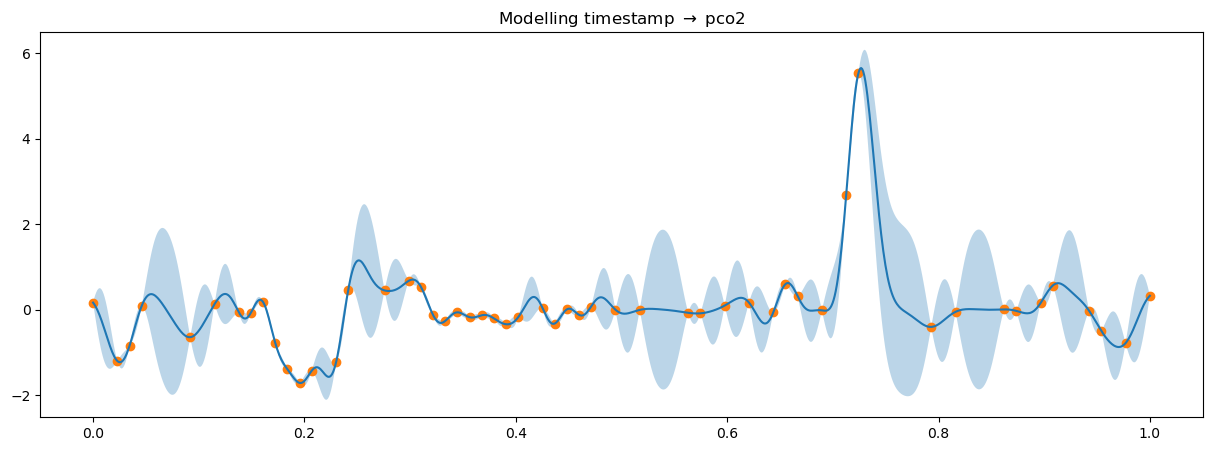

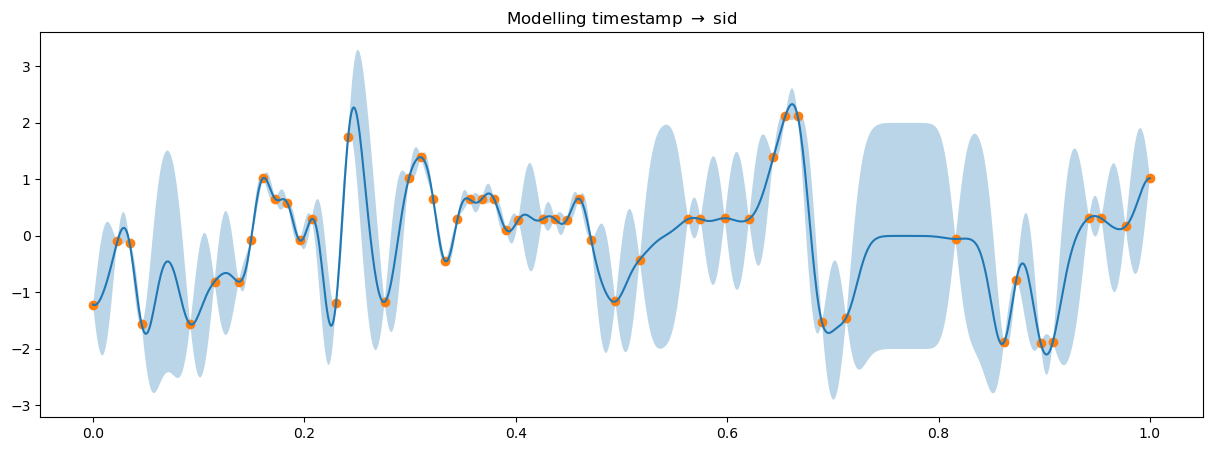

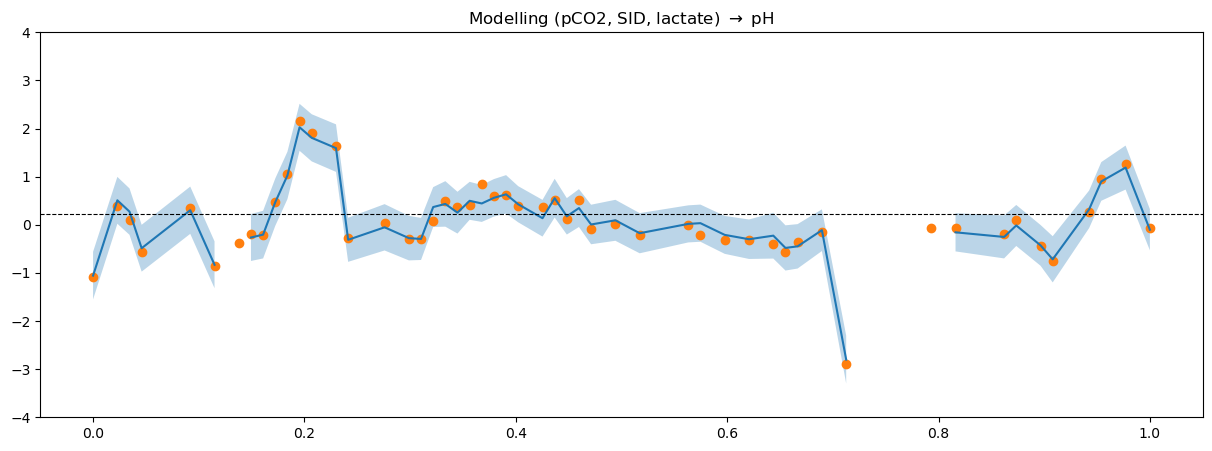

In [33]:
Xt = np.linspace(0, 1, 1000).reshape(-1, 1)

mu1, var1 = linked_gp._input_models[0].predict(Xt, method="mean_var")
lb1 = (mu1 - 2 * np.sqrt(var1)).flatten()
ub1 = (mu1 + 2 * np.sqrt(var1)).flatten()

mu2, var2 = linked_gp._input_models[1].predict(Xt, method="mean_var")
lb2 = (mu2 - 2 * np.sqrt(var2)).flatten()
ub2 = (mu2 + 2 * np.sqrt(var2)).flatten()

mu3, var3 = linked_gp._output_model.predict(H)
lb3 = (mu3 - 2 * np.sqrt(var3)).flatten()
ub3 = (mu3 + 2 * np.sqrt(var3)).flatten()

# Plotting

fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(Xt, mu1)
plt.fill_between(Xt.flatten(), lb1, ub1, alpha=0.3)
plt.scatter(X, H[:, 0])
plt.title(f"Modelling timestamp $\\rightarrow$ {features[0]}")

fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(Xt, mu2)
plt.fill_between(Xt.flatten(), lb2, ub2, alpha=0.3)
plt.scatter(X, H[:, 1])
plt.title(f"Modelling timestamp $\\rightarrow$ {features[1]}")

fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(X, mu3)
plt.fill_between(X.flatten(), lb3, ub3, alpha=0.3)
plt.scatter(X, Y)
plt.axhline(y_scaler.transform([[7.4]]), linestyle="--", linewidth=0.8, c="k")
plt.ylim(-4, 4)
plt.title(f"Modelling (pCO2, SID, lactate) $\\rightarrow$ pH");

# Experiment

In [34]:
windows = agg_patient.dropna(subset="ph").groupby('window').size()
windows[windows.ge(windows.quantile(.25))]

window
G-01 + 0      53
G-02 + 1      39
G-03 + 2      36
G-05 + 3      59
G-06 + 4      51
G-07 + 5      53
G-09 + 7      20
G-10 + 8     115
G-10 + 9      78
G-12 + 11     40
G-12 + 12     28
G-12 + 13     19
G-13 + 14     65
G-14 + 15     64
dtype: int64

In [35]:
def ampute(df, label_columns, p_missing):
    X = df.copy()
    n_missing_samples = int(p_missing * X.shape[0])
    for label_column in label_columns:
        indices = np.random.choice(X.index, n_missing_samples, replace=False)
        X.loc[indices, label_column] = np.nan
    return X

In [36]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

np.random.seed(10)

features = ["pco2", "sid", "lactate"]
maes = []
windows = agg_patient.dropna(subset="ph").groupby("window").size()
windows = windows[windows.gt(windows.quantile(0.25))].index
# windows = agg_patient[agg_patient["admission"] != -1]["window"].unique()

for p_missing in tqdm(np.arange(0.1, 0.5, 0.1)):
    for window in windows:
        patient_df = pd.read_csv(f"experiments/ph/{p_missing:.1f}_{window}_0_filled_ph.csv")

        for i in range(10):
            amputed_df = pd.read_csv(f"experiments/ph/{p_missing:.1f}_{window}_{i}_masked_ph.csv")

            patient_df["ph_nan"] = amputed_df["ph"]
            amputed_df = amputed_df.dropna(subset="ph")

            y_scaler = StandardScaler()
            Y = y_scaler.fit_transform(amputed_df[["ph"]].values)

            minmaxscaler = MinMaxScaler()
            X = minmaxscaler.fit_transform(amputed_df[["unix_timestamp"]].values)

            X_pred = minmaxscaler.transform(patient_df[["unix_timestamp"]].values)

            scaler = StandardScaler()
            H = scaler.fit_transform(amputed_df[features].values)

            # Linked GP
            linked_gp = LinkedGP(features=features)
            linked_gp.fit(X, H, Y)
            mean, var = linked_gp.predict(X_pred, full_layer=True)
            patient_df["ph_lgp"] = y_scaler.inverse_transform(np.hstack(mean[1])).flatten()

            # MICE
            imputer = IterativeImputer()
            patient_df["ph_mice"] = imputer.fit_transform(
                # patient_df[features + ["ph_nan"]]
                patient_df[["unix_timestamp", "ph_nan"]]
            )[:, -1]
            patient_df["ph_ffill"] = patient_df["ph_nan"].ffill().bfill()

            # Filtering masked values
            masked_df = patient_df[patient_df["ph_nan"].isna()]

            maes.append(
                {
                    "window": window,
                    "iter": i,
                    "n": patient_df.shape[0],
                    "p_missing": p_missing,
                    "mae lgp": mean_absolute_error(
                        masked_df["ph"], masked_df["ph_lgp"]
                    ),
                    "mae mice": mean_absolute_error(
                        masked_df["ph"], masked_df["ph_mice"]
                    ),
                    "mae ffill": mean_absolute_error(
                        masked_df["ph"], masked_df["ph_ffill"]
                    ),
                }
            )

    # pd.DataFrame(maes).to_parquet(f"results-lgp-{p_missing:.1f}.parquet")

  0%|          | 0/4 [00:00<?, ?it/s]/Users/ali.septiandri/miniforge3/envs/dgpsi/lib/python3.9/site-packages/dgpsi/kernel_class.py:188: RuntimeWarning: overflow encountered in exp
  theta=np.exp(log_theta)
/Users/ali.septiandri/miniforge3/envs/dgpsi/lib/python3.9/site-packages/dgpsi/kernel_class.py:98: RuntimeWarning: invalid value encountered in subtract
  self.g=lambda x: (self.prior_coef[0]-1)*np.log(x)-self.prior_coef[1]*x
/Users/ali.septiandri/miniforge3/envs/dgpsi/lib/python3.9/site-packages/dgpsi/kernel_class.py:245: RuntimeWarning: invalid value encountered in multiply
  nugget_fod=np.expand_dims(self.nugget*np.eye(n),0)
 25%|██▌       | 1/4 [00:02<00:08,  2.70s/it]/Users/ali.septiandri/miniforge3/envs/dgpsi/lib/python3.9/site-packages/dgpsi/kernel_class.py:188: RuntimeWarning: overflow encountered in exp
  theta=np.exp(log_theta)
/Users/ali.septiandri/miniforge3/envs/dgpsi/lib/python3.9/site-packages/dgpsi/kernel_class.py:98: RuntimeWarning: invalid value encountered in subtra

In [37]:
pd.DataFrame(maes).to_parquet("results/20241109/ph-linkedgp.parquet")

In [18]:
# pd.DataFrame(maes).to_parquet('results/20241107/ph-linkedgp.parquet')
maes = pd.read_parquet('results/20241107/ph-linkedgp.parquet')